In [1]:
import simdna
reload(simdna)
import simdna.synthetic as synthetic
reload(synthetic)
import gzip 
import h5py
import numpy as np

In [42]:
gata_file="DensityEmbedding_prefix-gata_motifs-GATA_disc1_min-1_max-3_mean-2_zeroProb-0_seqLength-200_numSeqs-1000.simdata.gz"
tal_file="DensityEmbedding_prefix-tal_motifs-TAL1_known1_min-1_max-3_mean-2_zeroProb-0_seqLength-200_numSeqs-1000.simdata.gz"
gata_tal_file="DensityEmbedding_prefix-talgata_motifs-GATA_disc1+TAL1_known1_min-1_max-3_mean-2_zeroProb-0_seqLength-200_numSeqs-1000.simdata.gz"
split='train'
train_ids_fh=gzip.open("splits/"+split+".txt.gz",'rb')
ids_to_load=[x.rstrip("\n") for x in train_ids_fh]

In [43]:
gata_data=synthetic.read_simdata_file(gata_file)
tal_data=synthetic.read_simdata_file(tal_file)
combined_data=synthetic.read_simdata_file(gata_tal_file)

In [44]:
#generate dictionary of embedding id to start & end positions 
pos_dict=dict() 
pos_dict['gata-']=dict() 
for i in range(len(gata_data.ids)): 
    cur_id=gata_data.ids[i]
    cur_embedding=gata_data.embeddings[i] 
    start_pos=[e.startPos for e in cur_embedding]
    end_pos=[e.startPos+len(e.what) for e in cur_embedding]
    pos_dict['gata-'][cur_id]=[start_pos,end_pos]
    
pos_dict['tal-']=dict() 
for i in range(len(tal_data.ids)): 
    cur_id=tal_data.ids[i]
    cur_embedding=tal_data.embeddings[i] 
    start_pos=[e.startPos for e in cur_embedding]
    end_pos=[e.startPos+len(e.what) for e in cur_embedding]
    pos_dict['tal-'][cur_id]=[start_pos,end_pos]

# The combined dictionary contains both tal & gata entries!! 
for i in range(len(combined_data.ids)): 
    cur_id=combined_data.ids[i]
    cur_embedding=combined_data.embeddings[i] 
    start_pos_gata=[] 
    start_pos_tal=[] 
    end_pos_gata=[] 
    end_pos_tal=[] 
    #print(cur_id+":"+str([e.what.getDescription() for e in cur_embedding]))
    #print(cur_id+":"+str([e.startPos for e in cur_embedding]))
    for e in cur_embedding: 
        e_start=e.startPos 
        e_end=e_start+len(e.what)
        e_description=e.what.getDescription() 
        if e_description=="GATA_disc1": 
            start_pos_gata.append(e_start)
            end_pos_gata.append(e_end)
        else: 
            start_pos_tal.append(e_start)
            end_pos_tal.append(e_end)
    #print(str(start_pos_tal))
    if len(start_pos_gata)>0:
        pos_dict['gata-'][cur_id]=[start_pos_gata,end_pos_gata]
    if len(start_pos_tal)>0:
        pos_dict['tal-'][cur_id]=[start_pos_tal,end_pos_tal]

In [46]:
#initialize arrays to store weights and true gradients
seq_length=200
num_channels=4
weights_gata=np.zeros((len(ids_to_load),seq_length))
weights_tal=np.zeros((len(ids_to_load),seq_length))
true_gradients_gata=np.zeros((len(ids_to_load),seq_length,num_channels))
true_gradients_tal=np.zeros((len(ids_to_load),seq_length,num_channels))

In [47]:
#initialize the motif log(pwm/background) for TAL & GATA 
gata_freqs=np.loadtxt("motif_freqs/GATA_disc1.freq")
tal_freqs=np.loadtxt("motif_freqs/TAL1_known1.freq")
background=np.array([0.276,0.277,0.222,0.222]) #A,C,G,T

In [48]:
#true gradients must be on the same scale as gradients computed by the model 
min_grad=-3 
max_grad=3

gata_pwm=np.log2(gata_freqs/background)
gata_pwm[gata_pwm<min_grad]=min_grad
gata_pwm[gata_pwm>max_grad]=max_grad

tal_pwm=np.log2(tal_freqs/background)
tal_pwm[tal_pwm<min_grad]=min_grad
tal_pwm[tal_pwm>max_grad]=max_grad

/users/annashch/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log2
/users/annashch/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log2


In [49]:
#Iterate through the sequences to fill in weights & gradients 
for i in range(len(ids_to_load)): 
    cur_id=ids_to_load[i]
    if cur_id in pos_dict['gata-']: 
        startpos=pos_dict['gata-'][cur_id][0]
        endpos=pos_dict['gata-'][cur_id][1]
        for entry in range(len(startpos)):
            weights_gata[i,startpos[entry]:endpos[entry]]=1
            true_gradients_gata[i,startpos[entry]:endpos[entry],:]=gata_pwm
    if cur_id in pos_dict['tal-']: 
        startpos=pos_dict['tal-'][cur_id][0] 
        endpos=pos_dict['tal-'][cur_id][1]
        for entry in range(len(startpos)):
            weights_tal[i,startpos[entry]:endpos[entry]]=1
            true_gradients_tal[i,startpos[entry]:endpos[entry],:]=tal_pwm
   

In [50]:
#save weights & gradients
np.save("weights_gata_"+split+".npy",weights_gata)
np.save("weights_tal_"+split+".npy",weights_tal)
np.save("gradients_gata_"+split+".npy",true_gradients_gata)
np.save("gradients_tal_"+split+".npy",true_gradients_tal)

In [51]:

from deeplift.visualization import viz_sequence 

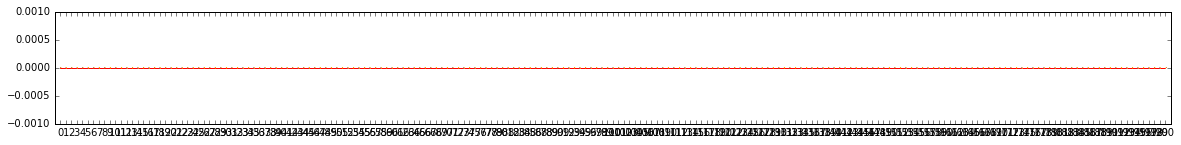

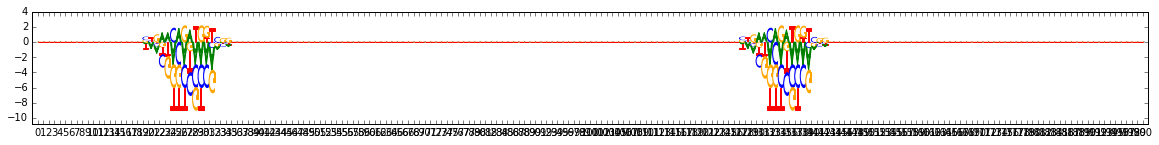

In [57]:
%matplotlib inline
viz_sequence.plot_weights(true_gradients_gata[0])
viz_sequence.plot_weights(true_gradients_tal[0])



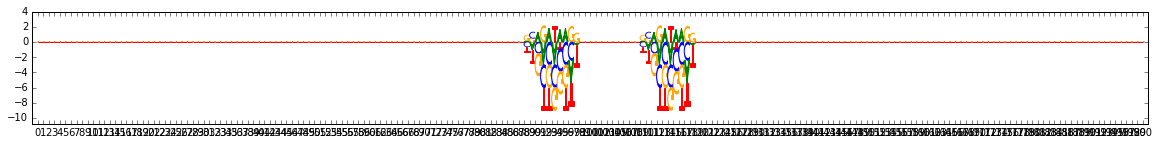

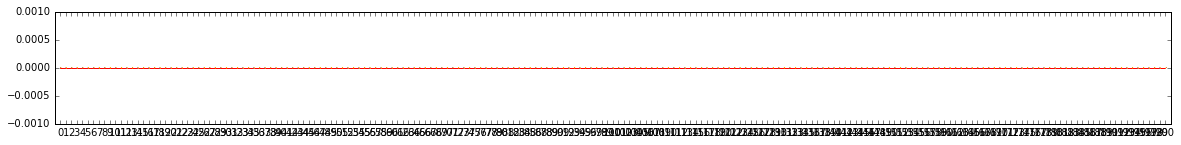

In [53]:
viz_sequence.plot_weights(true_gradients_gata[1])
viz_sequence.plot_weights(true_gradients_tal[1])

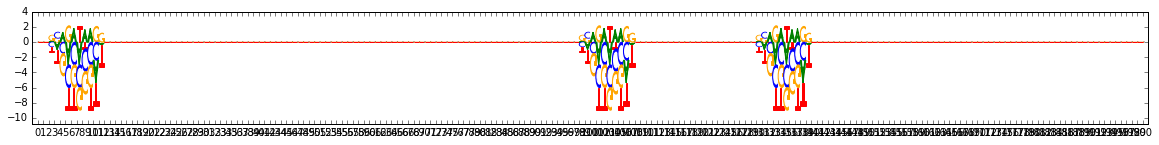

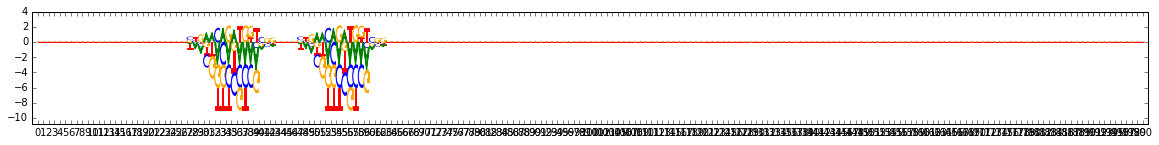

In [54]:
viz_sequence.plot_weights(true_gradients_gata[2])
viz_sequence.plot_weights(true_gradients_tal[2])

In [55]:
ids_to_load[0:10]

['tal-synth323',
 'gata-synth25',
 'talgata-synth734',
 'talgata-synth819',
 'tal-synth749',
 'talgata-synth17',
 'gata-synth259',
 'talgata-synth302',
 'talgata-synth369',
 'tal-synth47']